In [356]:
# Data loading
from utils import load_data

# Optimization (Optuna)
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# metrics / evaluation
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from numpy import rint
from numpy import load
from numpy import concatenate

# datetime
import datetime

# xgboost
import xgboost as xgb
from xgboost import XGBClassifier

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [555]:
X_train, X_val, X_test, y_train, y_val, y_test = load_data(win_size=100, step_size_1=3, step_size_0=20, win_begin=-15, win_end=5)

Samples fetched
Data fetched
all_samples shape: (331, 200, 11)
all_labels shape: (331,)
X_train shape: (231, 200, 11)
X_val shape: (50, 200, 11)
X_test shape: (50, 200, 11)
X_train shape: (2097, 100, 11), 1/0 ratio: 0.49356223175965663
X_val shape: (456, 100, 11), 1/0 ratio: 0.5
X_test shape: (454, 100, 11), 1/0 ratio: 0.4977973568281938


In [424]:
# merge X_train, X_val, X_test, y_train, y_val, y_test
X = concatenate((X_train, X_val, X_test))
y = concatenate((y_train, y_val, y_test))

In [231]:
# split X, y into 0 and 1 samples
X_0 = X[y == 0]
X_1 = X[y == 1]

count    116.000000
mean       0.001318
std        0.002670
min        0.000001
25%        0.000149
50%        0.000461
75%        0.001273
max        0.016668
dtype: float64
count    78.000000
mean      0.008196
std       0.006161
min       0.000562
25%       0.003442
50%       0.006348
75%       0.011002
max       0.025104
dtype: float64


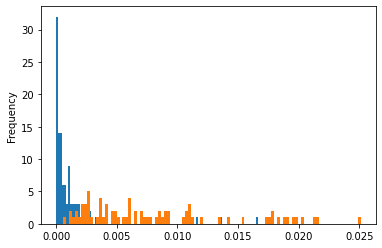

In [69]:
vars_0 = []
for sample in X_0:
    vars_0.append(sample[:,0:3].var())

vars_1 = []
for sample in X_1:
    vars_1.append(sample[:,0:3].var())

series_0 = pd.Series(vars_0)
series_1 = pd.Series(vars_1)

print(series_0.describe())
print(series_1.describe())

# plot the distribution of the variances
series_0.plot(kind='hist', bins=100)
series_1.plot(kind='hist', bins=100)
plt.show()

In [159]:
# disable scientific notation
np.set_printoptions(suppress=True)

In [163]:
sample.quantile(0.25, axis=0)

AttributeError: 'numpy.ndarray' object has no attribute 'quantile'

In [425]:
from scipy.stats import skew, kurtosis

def get_stats(X,y):
    X_stats = []
    labels = []

    for i, sample in enumerate(X):
        sample_stats = {}
        sample_stats['var'] = sample.var(axis=0)
        sample_stats['min'] = sample.min(axis=0)
        sample_stats['max'] = sample.max(axis=0)
        sample_stats['skew'] = skew(sample, axis=0)
        sample_stats['kurtosis'] = kurtosis(sample, axis=0)
        sample_stats['q025'] = np.percentile(sample, q=2.5, axis=0)
        sample_stats['q25'] = np.percentile(sample, q=25, axis=0)
        sample_stats['q50'] = np.percentile(sample, q=50, axis=0)
        sample_stats['q75'] = np.percentile(sample, q=75, axis=0)
        sample_stats['q95'] = np.percentile(sample, q=95, axis=0)

        X_stats.append(pd.DataFrame(sample_stats))

        # add label according to the value of y at the index of sample in X
        labels.append(y[i])

    return np.array(X_stats), np.array(labels)

In [233]:
X_stats = np.stack(X_stats)
labels = np.stack(labels)

In [234]:
print(X_stats.shape)

(2378, 7, 10)


In [556]:
X_train, y_train = get_stats(X_train, y_train)
X_val, y_val = get_stats(X_val, y_val)
X_test, y_test = get_stats(X_test, y_test)

In [557]:
# flatten X_train and X_val and X_test for Naive Bayes, XGBoost
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] * X_val.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

## XGBoost

In [564]:
# tune the hyperparameters
def objective(trial):
    # define the hyperparameters to tune
    eta = trial.suggest_loguniform("eta", 0.01, 0.5)
    max_depth = trial.suggest_int("max_depth", 1, 50)
    scale_pos_weight = trial.suggest_uniform("scale_pos_weight", 1, 50)
    subsample = trial.suggest_uniform("subsample", 0.6, 1.0)
    gamma = trial.suggest_uniform("gamma", 0.0, 1.0)

    # define the model
    model = XGBClassifier(
        eta=eta, max_depth=max_depth,  scale_pos_weight=scale_pos_weight, subsample=subsample, gamma=gamma, n_jobs=-1
    )
    # fit the model
    model.fit(X_train, y_train)
    # predict the test data
    preds = model.predict(X_val)
    pred_labels = np.rint(preds)
    #recall = sklearn.metrics.recall_score(valid_y, pred_labels)
    f_score = f1_score(y_val, pred_labels)
    return f_score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  200
Best trial:
  Value: 0.8943820224719101
  Params: 
    eta: 0.18099934503734993
    max_depth: 7
    scale_pos_weight: 31.70826491466733
    subsample: 0.7101481643618466
    gamma: 0.15699911564042396


In [565]:
# build the best model
best_params = study.best_trial.params
best_model = xgb.XGBClassifier(**best_params)
# fit the model
best_model.fit(X_train, y_train)
# predict the test data
pred_xgb = best_model.predict(X_test)
# get the f1 score
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

         0.0       0.86      0.91      0.89       228
         1.0       0.91      0.85      0.88       226

    accuracy                           0.88       454
   macro avg       0.88      0.88      0.88       454
weighted avg       0.88      0.88      0.88       454



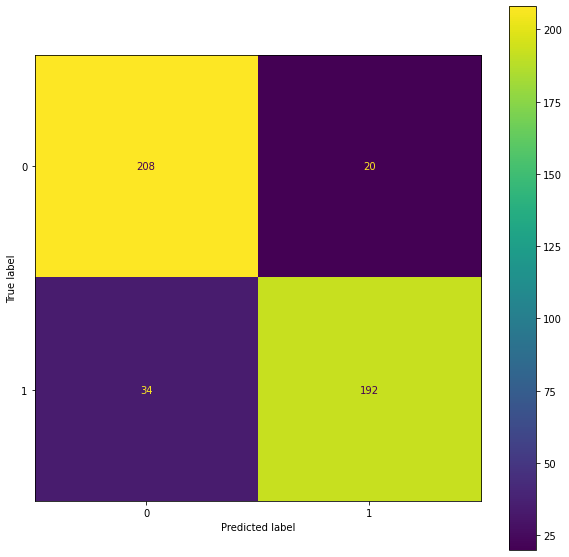

In [566]:
# get confusion matrix
plt.rcParams['figure.figsize'] = (10, 10)

cm = confusion_matrix(y_test, pred_xgb)
# plot confusion matrix

cm = confusion_matrix(y_test, pred_xgb, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()
plt.show()

In [552]:
optuna.visualization.plot_param_importances(study)

In [544]:
optuna.visualization.plot_optimization_history(study)

In [545]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

In [563]:
# save the model
best_model.save_model("../models/xgb-capybara-100-3.bin")

#load the model
#model = xgb.Booster(model_file="../models/xgb_model_2.bin")
# predict the test data
#model.predict(xgb.DMatrix(X_test))

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

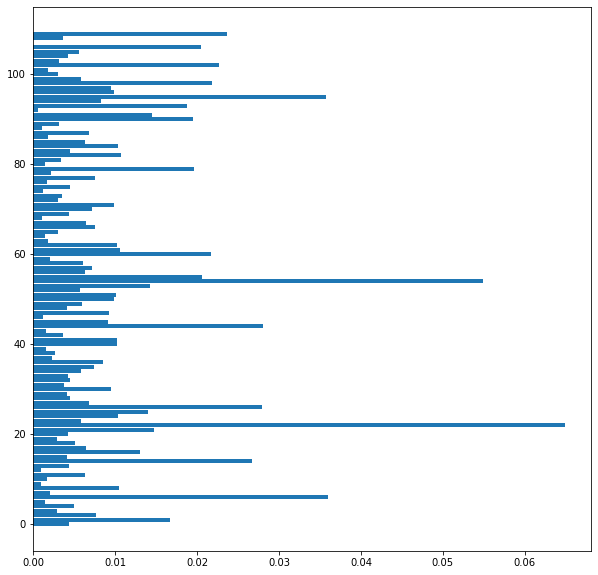

In [509]:
importance = best_model.feature_importances_
# plot the 10 most important features
plt.rcParams['figure.figsize'] = (10, 10)
plt.barh(range(len(importance)), importance, align='center')
plt.yticks(range(len(importance)), X_train.columns)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

## Naive Bayes

              precision    recall  f1-score   support

         0.0       0.83      0.72      0.77       363
         1.0       0.71      0.82      0.76       296

    accuracy                           0.77       659
   macro avg       0.77      0.77      0.77       659
weighted avg       0.78      0.77      0.77       659



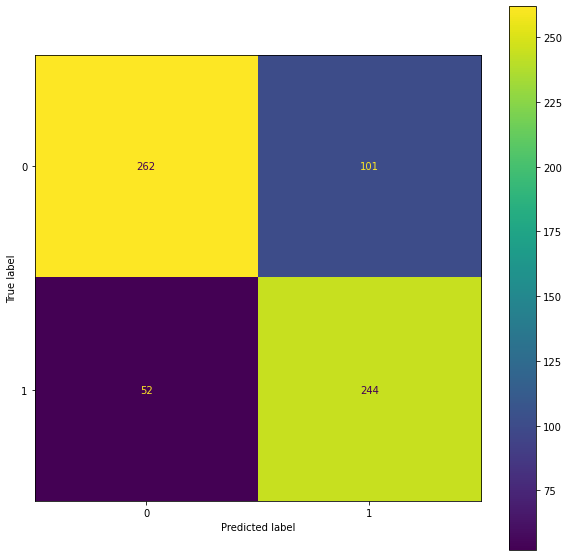

In [475]:
from sklearn.naive_bayes import GaussianNB
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)
pred_nb = naive_bayes.predict(X_test)
print(classification_report(y_test, pred_nb))

# get confusion matrix
plt.rcParams['figure.figsize'] = (10, 10)

cm = confusion_matrix(y_test, pred_nb, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()
plt.show()

## SVM

              precision    recall  f1-score   support

         0.0       0.89      0.52      0.65        33
         1.0       0.38      0.83      0.53        12

    accuracy                           0.60        45
   macro avg       0.64      0.67      0.59        45
weighted avg       0.76      0.60      0.62        45



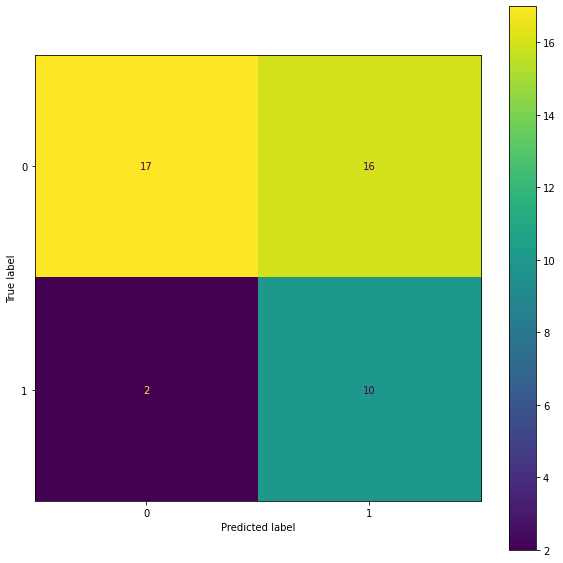

In [435]:
from sklearn.svm import SVC

svc = SVC(kernel='sigmoid', C=1, degree=4, gamma='scale', random_state=42, class_weight='balanced')
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)
print(classification_report(y_test, pred_svc))

# get confusion matrix
plt.rcParams['figure.figsize'] = (10, 10)

cm = confusion_matrix(y_test, pred_svc, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()
plt.show()

## Random Forest Classifier

              precision    recall  f1-score   support

         0.0       0.90      0.80      0.85       363
         1.0       0.79      0.90      0.84       296

    accuracy                           0.85       659
   macro avg       0.85      0.85      0.84       659
weighted avg       0.85      0.85      0.85       659



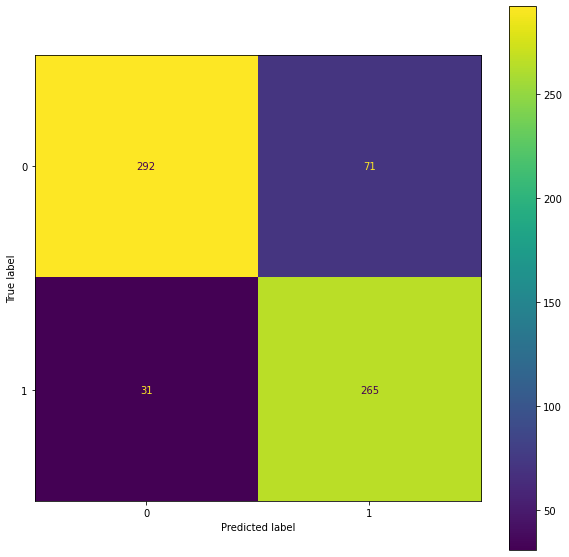

In [482]:
# import random forest
from sklearn.ensemble import RandomForestClassifier

# define the model
rf = RandomForestClassifier(n_estimators=200, max_depth=3, class_weight='balanced', random_state=42, )
# fit the model
rf.fit(X_train, y_train)
# predict the test data
pred_rf = rf.predict(X_test)
# get the f1 score
print(classification_report(y_test, pred_rf))

# get confusion matrix
plt.rcParams['figure.figsize'] = (10, 10)

cm = confusion_matrix(y_test, pred_rf, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()
plt.show()

In [483]:
# feature importance
importance = rf.feature_importances_

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

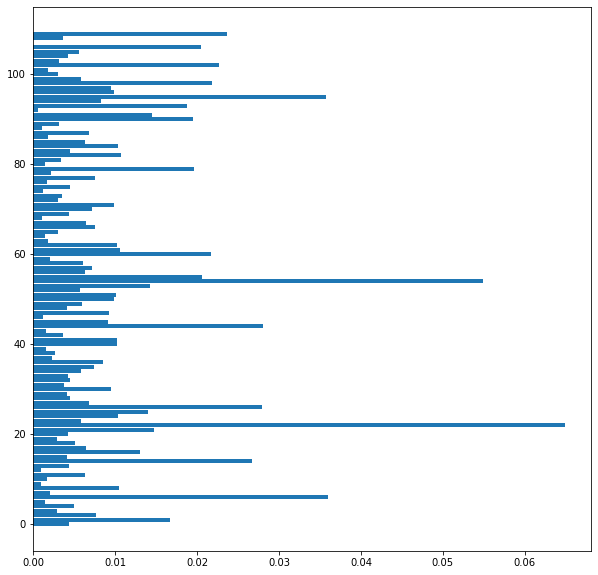

In [511]:
# plot as bar plot
plt.rcParams['figure.figsize'] = (10, 10)
plt.barh(range(len(importance)), importance, align='center')
plt.yticks(range(len(importance)), X_train.columns)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

## Logistic Regression

              precision    recall  f1-score   support

         0.0       0.68      0.79      0.73       198
         1.0       0.79      0.67      0.73       230

    accuracy                           0.73       428
   macro avg       0.73      0.73      0.73       428
weighted avg       0.74      0.73      0.73       428



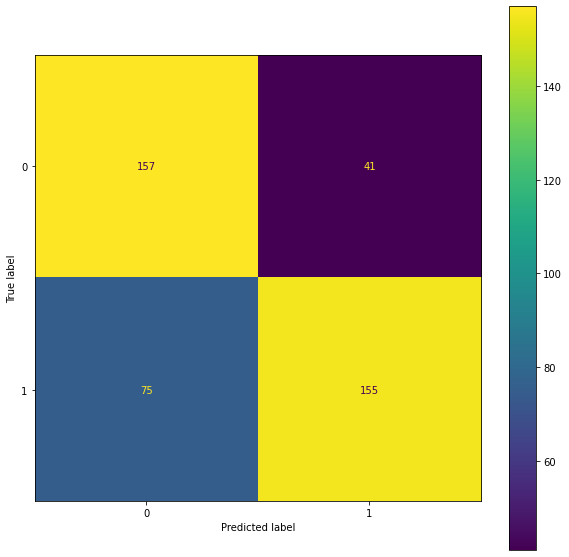

In [539]:
# import logistic regression
from sklearn.linear_model import LogisticRegression

# define the model
logreg = LogisticRegression(C=1, class_weight='balanced', random_state=42, max_iter=10000, solver='liblinear')
# fit the model
logreg.fit(X_train, y_train)
# predict the test data
pred_logreg = logreg.predict(X_test)
# get the f1 score
print(classification_report(y_test, pred_logreg))

# get confusion matrix
plt.rcParams['figure.figsize'] = (10, 10)

cm = confusion_matrix(y_test, pred_logreg, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()
plt.show()

## Evaluation

/Users/benschaper/Library/Caches/pypoetry/virtualenvs/ai-model-training-ZBO0jvbE-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/benschaper/Library/Caches/pypoetry/virtualenvs/ai-model-training-ZBO0jvbE-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



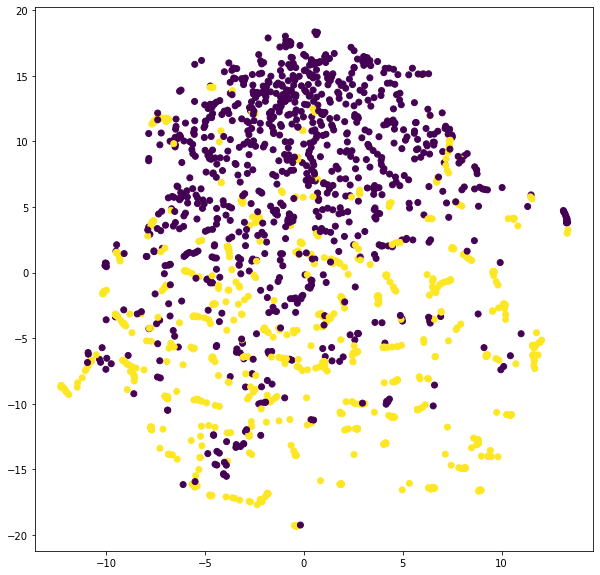

In [512]:
# plot all samples using tsne and color by label
from sklearn.manifold import TSNE

# define the tsne model
tsne = TSNE(n_components=2, perplexity=50, n_iter=300)
# fit the model
tsne.fit_transform(X_train)
# plot the result
plt.scatter(tsne.embedding_[:, 0], tsne.embedding_[:, 1], c=y_train)
plt.show()

## Neural Net

In [439]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from tensorflow_addons.metrics import F1Score
# l2
# pooling
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.regularizers import l2

In [444]:
input = Input(shape=(X_train.shape[1],))
o = Dense(units=32, activation='leaky_relu', kernel_regularizer='l1_l2')(input)
o = Dropout(0.5)(o)

o = Dense(units=32, activation='leaky_relu', kernel_regularizer='l1_l2')(o)
o = Dropout(0.5)(o)

o = Dense(units=1, activation='sigmoid')(o)
model = Model(inputs=input, outputs=o)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[Precision(name="precision"), Recall(name="recall"), F1Score(name="f1", average="micro", threshold=0.5, num_classes=2)])
model.summary()

Model: "model_151"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_177 (InputLayer)      [(None, 110)]             0         
                                                                 
 dense_370 (Dense)           (None, 32)                3552      
                                                                 
 dropout_199 (Dropout)       (None, 32)                0         
                                                                 
 dense_371 (Dense)           (None, 32)                1056      
                                                                 
 dropout_200 (Dropout)       (None, 32)                0         
                                                                 
 dense_372 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable

In [445]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[EarlyStopping(monitor='val_f1', patience=100, mode='max', restore_best_weights=True)])

Epoch 1/100
7/7 [==============================] - 1s 51ms/step - loss: 8.8224 - precision: 0.2519 - recall: 0.6000 - f1: 0.3548 - val_loss: 7.2883 - val_precision: 0.2759 - val_recall: 0.7273 - val_f1: 0.4000
Epoch 2/100
7/7 [==============================] - 0s 4ms/step - loss: 8.3568 - precision: 0.2347 - recall: 0.4182 - f1: 0.3007 - val_loss: 6.7258 - val_precision: 0.3158 - val_recall: 0.5455 - val_f1: 0.4000
Epoch 3/100
7/7 [==============================] - 0s 4ms/step - loss: 7.9525 - precision: 0.2680 - recall: 0.4727 - f1: 0.3421 - val_loss: 6.3458 - val_precision: 0.3333 - val_recall: 0.4545 - val_f1: 0.3846
Epoch 4/100
7/7 [==============================] - 0s 4ms/step - loss: 7.2973 - precision: 0.2796 - recall: 0.4727 - f1: 0.3514 - val_loss: 6.0286 - val_precision: 0.4167 - val_recall: 0.4545 - val_f1: 0.4348
Epoch 5/100
7/7 [==============================] - 0s 4ms/step - loss: 6.8967 - precision: 0.2800 - recall: 0.5091 - f1: 0.3613 - val_loss: 5.7255 - val_precision:

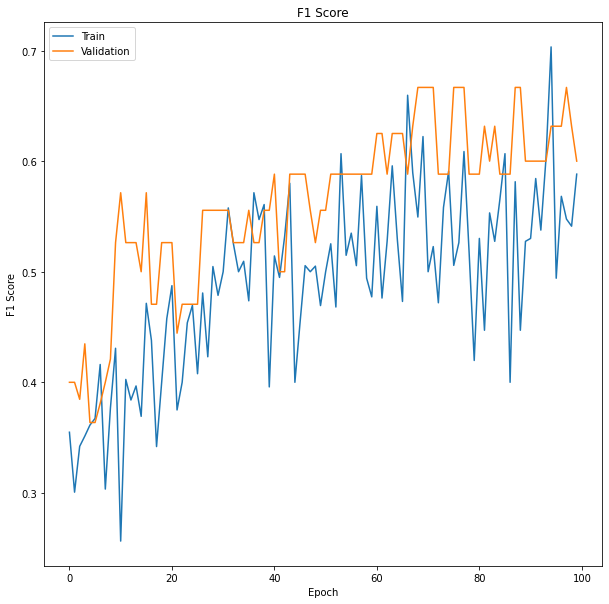

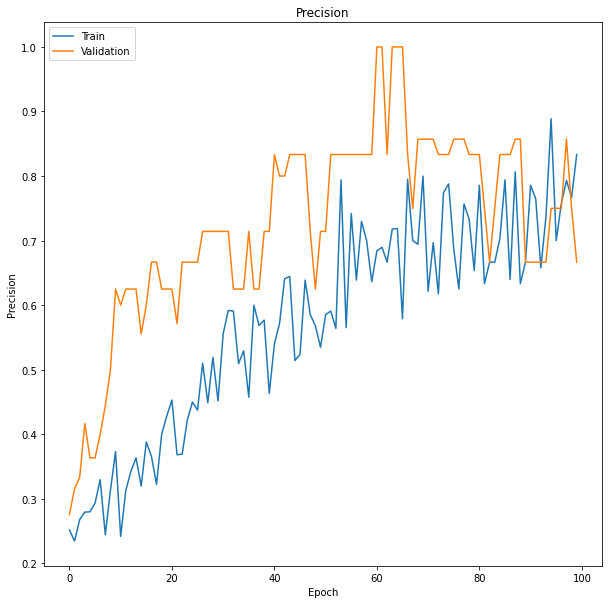

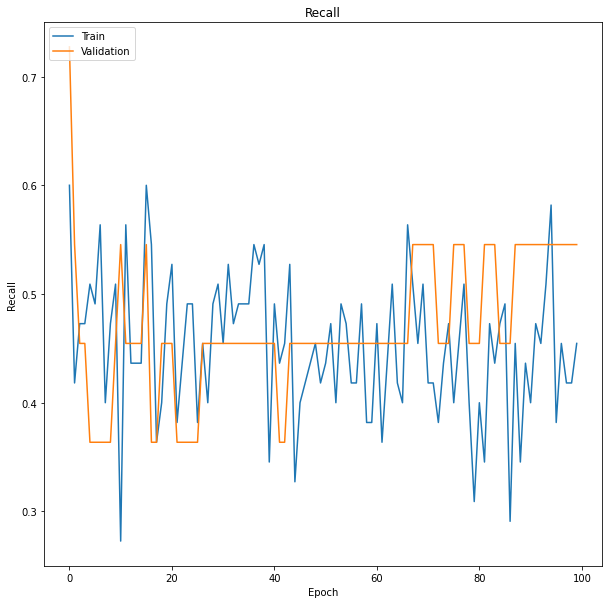

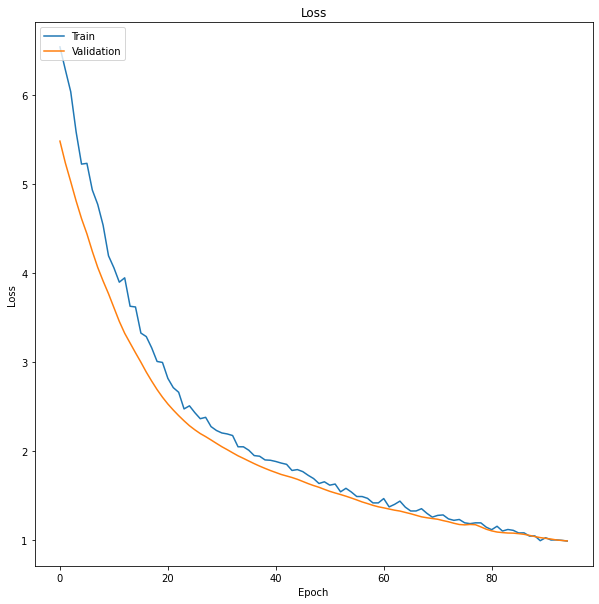

In [446]:
# plot the training history
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'][5:])
plt.plot(history.history['val_loss'][5:])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

2/2 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.78      0.94      0.85        33
         1.0       0.60      0.25      0.35        12

    accuracy                           0.76        45
   macro avg       0.69      0.59      0.60        45
weighted avg       0.73      0.76      0.72        45



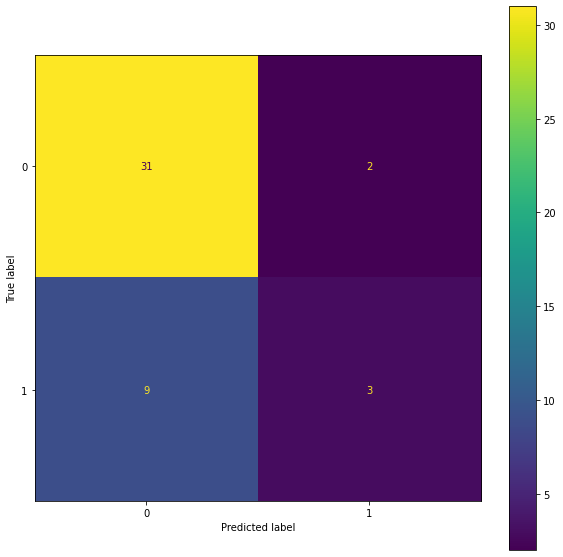

In [447]:
preds = model.predict(X_test)
preds = rint(preds)
# get the f1 score
print(classification_report(y_test, preds))

# get confusion matrix
plt.rcParams['figure.figsize'] = (10, 10)

cm = confusion_matrix(y_test, preds)
# plot confusion matrix

cm = confusion_matrix(y_test, preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()
plt.show()

## Conv1D

In [132]:
import tensorflow as tf

In [338]:
#seed
tf.random.set_seed(42)

In [349]:
import random
from datetime import datetime
from wandb.keras import WandbCallback

TIME = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

In [354]:

def run():

    seed = random.randint(0, 100)
    tf.random.set_seed(seed)
    config = {"seed": seed}
    # init wandb
    wandb.init(entity="protechted", project=f"fall-detection", group=f"optuna_CNN_{TIME}", reinit=True, config=config)

    input = Input(shape=(X_train.shape[1],1))
    o = Conv1D(filters=11, kernel_size=10, strides=10)(input)
    o = Conv1D(filters=8, kernel_size=3, strides=2)(o)
    o = Flatten()(o)

    o = Dense(units=32, activation='leaky_relu', kernel_regularizer='l1_l2')(o)
    o = Dropout(0.5)(o)
    #o = Dense(units=32, activation='leaky_relu', kernel_regularizer='l1_l2')(o)
    #o = Dropout(0.6)(o)

    o = Dense(units=1, activation='sigmoid')(o)
    model = Model(inputs=input, outputs=o)


    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[Precision(name="precision"), Recall(name="recall"), F1Score(name="f1", average="micro", threshold=0.5, num_classes=2)])
    model.summary()

    model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[EarlyStopping(monitor='val_f1', patience=20, mode='max', restore_best_weights=True), WandbCallback( monitor='val_f1', save_model=True, mode='max')])

    preds = model.predict(X_test)
    pred_labels = rint(preds)
    f1 = f1_score(y_test, pred_labels)
    wandb.log({"test_f1": f1})

In [343]:
import wandb
import optuna

In [355]:
for i in range(20):
    run()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████████
loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▂▃▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
recall,▁▇██▇▇▇▆▇▇▇▇▇▇▇▇█▇████▇█████████████████
val_f1,▁▂▃▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇█▇█▇█▇▇██▇██████
val_loss,█▇▆▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▂▃▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇█▇█▇█▇▇█▇▇██████
val_recall,█▄▄▁▁▁▁▁▁▁▁▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
best_epoch,19
best_val_f1,0.97364


Model: "model_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_156 (InputLayer)      [(None, 110, 1)]          0         
                                                                 
 conv1d_225 (Conv1D)         (None, 11, 11)            121       
                                                                 
 conv1d_226 (Conv1D)         (None, 5, 8)              272       
                                                                 
 flatten_108 (Flatten)       (None, 40)                0         
                                                                 
 dense_327 (Dense)           (None, 32)                1312      
                                                                 
 dropout_177 (Dropout)       (None, 32)                0         
                                                                 
 dense_328 (Dense)           (None, 1)                 33

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
f1,▁▃▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇▇█▇▇▇████████████
loss,█▆▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▂▃▅▅▆▆▆▇▇▇▇▇▇███████████▇▇█████████████
recall,▂▇▅▄▂▁▂▂▂▂▃▃▄▅▅▅▄▅▅▅▆▆▅▅▆▆▆▆▆▅▆▇▇▇▇▇█▇▇█
test_f1,▁
val_f1,▁▃▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇█████████▇███▇██
val_loss,█▆▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▃▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▆▇▇██▇█████████▇███▇██
val_recall,█▄▄▁▁▁▁▁▁▁▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
best_epoch,22


Model: "model_131"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_157 (InputLayer)      [(None, 110, 1)]          0         
                                                                 
 conv1d_227 (Conv1D)         (None, 11, 11)            121       
                                                                 
 conv1d_228 (Conv1D)         (None, 5, 8)              272       
                                                                 
 flatten_109 (Flatten)       (None, 40)                0         
                                                                 
 dense_329 (Dense)           (None, 32)                1312      
                                                                 
 dropout_178 (Dropout)       (None, 32)                0         
                                                                 
 dense_330 (Dense)           (None, 1)                 33

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
loss,█▆▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▃▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
recall,▂▇▂▂▁▂▂▃▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▆▅▆▆▇▆▇▇▇▇▇▇▇▇▇█
test_f1,▁
val_f1,▁▄▆▆▆▆▆▆▇▇▇▆▇▇▇▇▇█▇▇▇▇▇███████████████▇█
val_loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▄▆▆▆▆▆▆▇▇▇▆▇▇▇▇▇█▇▇▇▇▇▇▇▇███▇▇█▇▇▇█▇▇▇▇
val_recall,██▁▁▁▁██████████████████████████████████
best_epoch,43


Model: "model_132"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_158 (InputLayer)      [(None, 110, 1)]          0         
                                                                 
 conv1d_229 (Conv1D)         (None, 11, 11)            121       
                                                                 
 conv1d_230 (Conv1D)         (None, 5, 8)              272       
                                                                 
 flatten_110 (Flatten)       (None, 40)                0         
                                                                 
 dense_331 (Dense)           (None, 32)                1312      
                                                                 
 dropout_179 (Dropout)       (None, 32)                0         
                                                                 
 dense_332 (Dense)           (None, 1)                 33

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
f1,▁▃▄▅▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇█▇█▇██▇▇██████████
loss,█▆▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▂▄▅▆▆▇▇▇▇▇▇▇▇▇██████████████████████
recall,▅█▇▅▄▂▂▁▁▁▂▂▁▂▂▃▃▃▃▄▃▄▃▄▃▄▄▄▄▄▄▄▄▄▄▄▅
test_f1,▁
val_f1,▁▃▅▆▇▇▆▆▆▇▇▆▆▇▆▇█▆█▇█▇███▇▇███████▇██
val_loss,█▆▅▄▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▃▄▆▇▇▆▆▆▇▇██▇█▇███▇█▇███▇▇██████████
val_recall,████▇▇█▇▇▇▇▁▂█▁██▁████████████████▅██
best_epoch,16


Model: "model_133"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_159 (InputLayer)      [(None, 110, 1)]          0         
                                                                 
 conv1d_231 (Conv1D)         (None, 11, 11)            121       
                                                                 
 conv1d_232 (Conv1D)         (None, 5, 8)              272       
                                                                 
 flatten_111 (Flatten)       (None, 40)                0         
                                                                 
 dense_333 (Dense)           (None, 32)                1312      
                                                                 
 dropout_180 (Dropout)       (None, 32)                0         
                                                                 
 dense_334 (Dense)           (None, 1)                 33

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█████████████████
loss,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▃▅▆▆▇▇▇▇▇▇▇▇████▇▇▇████████████████████
recall,▁▇▆▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇█████████
test_f1,▁
val_f1,▁▅▆▆▆▆▇█▇████▇█▇▇▇██████████████████████
val_loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▅▆▆▆▆▆█▇████▇█▇▇▇██████████████████████
val_recall,█▁▁▁▁▁▁▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
best_epoch,61


Model: "model_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_160 (InputLayer)      [(None, 110, 1)]          0         
                                                                 
 conv1d_233 (Conv1D)         (None, 11, 11)            121       
                                                                 
 conv1d_234 (Conv1D)         (None, 5, 8)              272       
                                                                 
 flatten_112 (Flatten)       (None, 40)                0         
                                                                 
 dense_335 (Dense)           (None, 32)                1312      
                                                                 
 dropout_181 (Dropout)       (None, 32)                0         
                                                                 
 dense_336 (Dense)           (None, 1)                 33

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▅▅▆▆▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇███████████████████
loss,█▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▂▃▅▆▆▆▇▇▇▇▇▇▇▇██▇██████████████████████
recall,▁██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇██████████████
test_f1,▁
val_f1,▁▃▄▅▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇███▇█████████████
val_loss,█▇▆▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▂▄▅▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇██▇█████████████
val_recall,██▆▃▃▃▃▃▁▃▁▃▃▃▁▁▃▃▃▃▃▃▃▆▃▃▆▃▆▆▆▃▆▆▆▆▆▆▆▆
best_epoch,36


Model: "model_135"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_161 (InputLayer)      [(None, 110, 1)]          0         
                                                                 
 conv1d_235 (Conv1D)         (None, 11, 11)            121       
                                                                 
 conv1d_236 (Conv1D)         (None, 5, 8)              272       
                                                                 
 flatten_113 (Flatten)       (None, 40)                0         
                                                                 
 dense_337 (Dense)           (None, 32)                1312      
                                                                 
 dropout_182 (Dropout)       (None, 32)                0         
                                                                 
 dense_338 (Dense)           (None, 1)                 33

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇██▇█▇██████▇██████████
loss,█▆▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▃▄▆▆▆▇▇▇▇▇▇▇▇█▇████████████████████████
recall,▁▆▅▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇
test_f1,▁
val_f1,▁▄▅▆▅▆▆▇▆▆▇████████▇█▇█▇▇█▇█▇▇██████████
val_loss,█▆▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▃▅▆▅▆▆▇▆█▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█▇▇██████████
val_recall,██▇▇▇▇▇▇▇▁▇█████████████████████████████
best_epoch,36


Model: "model_136"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_162 (InputLayer)      [(None, 110, 1)]          0         
                                                                 
 conv1d_237 (Conv1D)         (None, 11, 11)            121       
                                                                 
 conv1d_238 (Conv1D)         (None, 5, 8)              272       
                                                                 
 flatten_114 (Flatten)       (None, 40)                0         
                                                                 
 dense_339 (Dense)           (None, 32)                1312      
                                                                 
 dropout_183 (Dropout)       (None, 32)                0         
                                                                 
 dense_340 (Dense)           (None, 1)                 33

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1,▁▃▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇█████████████████████
loss,█▆▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▂▄▅▆▆▆▇▇▇▇▇▇▇▇███▇█████████████████████
recall,▁▇▇▅▅▅▅▆▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██
test_f1,▁
val_f1,▁▃▅▅▆▆▇▆▇▇▇▇▇▇▆██▇▇▇▇▇▇▇█▇▇██████▇██▇█▇█
val_loss,█▆▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▂▅▅▆▆▆▆▆▆▇▇▇▇▆██▇▇▇▇▇▇▇█▇▇██████▇██▇█▇█
val_recall,██▁▁▁▁▁▁▁▁▁▁▁▁▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
best_epoch,30


Model: "model_137"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_163 (InputLayer)      [(None, 110, 1)]          0         
                                                                 
 conv1d_239 (Conv1D)         (None, 11, 11)            121       
                                                                 
 conv1d_240 (Conv1D)         (None, 5, 8)              272       
                                                                 
 flatten_115 (Flatten)       (None, 40)                0         
                                                                 
 dense_341 (Dense)           (None, 32)                1312      
                                                                 
 dropout_184 (Dropout)       (None, 32)                0         
                                                                 
 dense_342 (Dense)           (None, 1)                 33

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▂▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇█▇█▇█▇██▇█████▇██████
loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▂▄▆▆▇▇▇▇▇▇▇█▇██████████████████████████
recall,▁▇▆▄▂▃▂▂▂▄▅▅▅▅▅▆▆▆▆▆▅▆▅▆▅▆▆▆▆▆▆▆▆▇▆▇████
test_f1,▁
val_f1,▁▃▅▆▇▇▇▇▇█▇█▇▇▇▇▇██████████████▇███████▇
val_loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▃▅▆▇▆▇█▇█▇█▇▇▇▇▇██████████████▇███████▇
val_recall,██▆▆▆▆▆▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
best_epoch,48


Model: "model_138"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_164 (InputLayer)      [(None, 110, 1)]          0         
                                                                 
 conv1d_241 (Conv1D)         (None, 11, 11)            121       
                                                                 
 conv1d_242 (Conv1D)         (None, 5, 8)              272       
                                                                 
 flatten_116 (Flatten)       (None, 40)                0         
                                                                 
 dense_343 (Dense)           (None, 32)                1312      
                                                                 
 dropout_185 (Dropout)       (None, 32)                0         
                                                                 
 dense_344 (Dense)           (None, 1)                 33

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇█▇▇█████████████████████
loss,█▆▅▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇████████████████████████
recall,▁▇█▆▆▆▆▆▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇▇▇██████
test_f1,▁
val_f1,▁▂▄▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇█▇▇▇█████▇██▇
val_loss,█▇▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▂▃▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇▆▇▇▇█▇▇▇▇▇▇▇
val_recall,██▄▄▄▄▄▁▁▄▄▄▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
best_epoch,33


Model: "model_139"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_165 (InputLayer)      [(None, 110, 1)]          0         
                                                                 
 conv1d_243 (Conv1D)         (None, 11, 11)            121       
                                                                 
 conv1d_244 (Conv1D)         (None, 5, 8)              272       
                                                                 
 flatten_117 (Flatten)       (None, 40)                0         
                                                                 
 dense_345 (Dense)           (None, 32)                1312      
                                                                 
 dropout_186 (Dropout)       (None, 32)                0         
                                                                 
 dense_346 (Dense)           (None, 1)                 33

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▄▄▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇█████████████
loss,█▆▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▂▃▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██▇███████████████████
recall,▁█▇▆▆▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇███████
test_f1,▁
val_f1,▁▃▄▆▆▆▆▆▆▆▇▆▇▇▇█▇▇▇▇▇█▇▇████████████▇███
val_loss,█▆▅▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▃▄▆▆▆▆▆▆▆▆▆▇▇▇█▇▇▇▇▇█▇▇████████████▇███
val_recall,██▄▁▁▁▁▁▁▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
best_epoch,36


Model: "model_140"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_166 (InputLayer)      [(None, 110, 1)]          0         
                                                                 
 conv1d_245 (Conv1D)         (None, 11, 11)            121       
                                                                 
 conv1d_246 (Conv1D)         (None, 5, 8)              272       
                                                                 
 flatten_118 (Flatten)       (None, 40)                0         
                                                                 
 dense_347 (Dense)           (None, 32)                1312      
                                                                 
 dropout_187 (Dropout)       (None, 32)                0         
                                                                 
 dense_348 (Dense)           (None, 1)                 33

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█████████████████
loss,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▃▅▆▆▇▇▇▇▇▇▇▇████▇▇▇████████████████████
recall,▁▇▆▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇█████████
test_f1,▁
val_f1,▁▅▆▆▆▆▇█▇████▇█▇▇▇██████████████████████
val_loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▅▆▆▆▆▆█▇████▇█▇▇▇██████████████████████
val_recall,█▁▁▁▁▁▁▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
best_epoch,61


Model: "model_141"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_167 (InputLayer)      [(None, 110, 1)]          0         
                                                                 
 conv1d_247 (Conv1D)         (None, 11, 11)            121       
                                                                 
 conv1d_248 (Conv1D)         (None, 5, 8)              272       
                                                                 
 flatten_119 (Flatten)       (None, 40)                0         
                                                                 
 dense_349 (Dense)           (None, 32)                1312      
                                                                 
 dropout_188 (Dropout)       (None, 32)                0         
                                                                 
 dense_350 (Dense)           (None, 1)                 33

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▃▄▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇██████████
loss,█▆▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▃▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████▇███████████████
recall,▂▂▁▁▂▁▂▁▁▂▂▂▂▂▁▃▃▄▃▄▄▃▄▄▅▅▆▅▆▆▇█▇▇▇█████
test_f1,▁
val_f1,▁▃▄▅▅▆▆▆▆▇▆▆▇▇▇▇▆▇▇▇▇▆▇▇█▇██▇███████▆██▇
val_loss,█▆▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▃▄▅▅▆▆▆▆▇▆▆▇▇▇▇▆▇▇▇▇▆▇▇█▇██▇████▇██▆██▇
val_recall,▅▅▅▅▅▅▁▅▅▁▅▅▁▅██████████████████████████
best_epoch,32


Model: "model_142"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_168 (InputLayer)      [(None, 110, 1)]          0         
                                                                 
 conv1d_249 (Conv1D)         (None, 11, 11)            121       
                                                                 
 conv1d_250 (Conv1D)         (None, 5, 8)              272       
                                                                 
 flatten_120 (Flatten)       (None, 40)                0         
                                                                 
 dense_351 (Dense)           (None, 32)                1312      
                                                                 
 dropout_189 (Dropout)       (None, 32)                0         
                                                                 
 dense_352 (Dense)           (None, 1)                 33

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1,▁▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████████
loss,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▃▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
recall,▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█████████████████████
test_f1,▁
val_f1,▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇██▇██████▇████
val_loss,█▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇██▇██████▇████
val_recall,█▆▃▃▃▃▃▃▃▃▃▃▃▁▃▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
best_epoch,59


Model: "model_143"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_169 (InputLayer)      [(None, 110, 1)]          0         
                                                                 
 conv1d_251 (Conv1D)         (None, 11, 11)            121       
                                                                 
 conv1d_252 (Conv1D)         (None, 5, 8)              272       
                                                                 
 flatten_121 (Flatten)       (None, 40)                0         
                                                                 
 dense_353 (Dense)           (None, 32)                1312      
                                                                 
 dropout_190 (Dropout)       (None, 32)                0         
                                                                 
 dense_354 (Dense)           (None, 1)                 33

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▃▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▃▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇████████████████
recall,▁▅▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▅▆▆▆▆▆▇▇▆▇▇▇▇██▇██
test_f1,▁
val_f1,▁▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇███▇█████
val_loss,█▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▄▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇█
val_recall,█▆▅▅▅▅▅▅▃▁▁▁▁▅▁▅▅▅▅▃▅▁▅▃▅▃▅▅▅▃▅▅▅▅▅▅▅▅▅▃
best_epoch,57


Model: "model_144"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_170 (InputLayer)      [(None, 110, 1)]          0         
                                                                 
 conv1d_253 (Conv1D)         (None, 11, 11)            121       
                                                                 
 conv1d_254 (Conv1D)         (None, 5, 8)              272       
                                                                 
 flatten_122 (Flatten)       (None, 40)                0         
                                                                 
 dense_355 (Dense)           (None, 32)                1312      
                                                                 
 dropout_191 (Dropout)       (None, 32)                0         
                                                                 
 dense_356 (Dense)           (None, 1)                 33

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇██████████████
loss,█▆▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▂▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█████████████████
recall,▂█▃▂▃▂▂▂▁▃▃▃▃▃▃▃▄▃▄▅▅▅▅▇▇▆▇▆▇█▇▇▇███████
test_f1,▁
val_f1,▁▄▅▅▆▆▆▇▇▇██▇██▇▇▇▇▇▇█▇█████████▇███▇███
val_loss,█▆▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▃▅▅▆▆▆▇▇▇██▇██▇▇▇▇▇▇▇▇████████▇▇███▇███
val_recall,█▄▄▁▁▁▁▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
best_epoch,38


Model: "model_145"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_171 (InputLayer)      [(None, 110, 1)]          0         
                                                                 
 conv1d_255 (Conv1D)         (None, 11, 11)            121       
                                                                 
 conv1d_256 (Conv1D)         (None, 5, 8)              272       
                                                                 
 flatten_123 (Flatten)       (None, 40)                0         
                                                                 
 dense_357 (Dense)           (None, 32)                1312      
                                                                 
 dropout_192 (Dropout)       (None, 32)                0         
                                                                 
 dense_358 (Dense)           (None, 1)                 33

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▃▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██▇█████████
loss,█▆▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▃▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇██▇███████████████
recall,▁█▆▆▄▃▄▄▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▅▅▇▆▆▇▆▅▆▇▇▆▆▇█▇█
test_f1,▁
val_f1,▁▄▅▆▆▇▆▇▇▅▇█▇██▇█▇▇▇█▇█▇██████████▇█▇█▇█
val_loss,█▆▅▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▃▅▆▆▇▆▇▆█▇█▇███████████████████▇█▇█▇█▇█
val_recall,█████████▁█▇█▇▇▆▇▅▅▅▇▆█▆▇████▇▇█████████
best_epoch,33


Model: "model_146"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_172 (InputLayer)      [(None, 110, 1)]          0         
                                                                 
 conv1d_257 (Conv1D)         (None, 11, 11)            121       
                                                                 
 conv1d_258 (Conv1D)         (None, 5, 8)              272       
                                                                 
 flatten_124 (Flatten)       (None, 40)                0         
                                                                 
 dense_359 (Dense)           (None, 32)                1312      
                                                                 
 dropout_193 (Dropout)       (None, 32)                0         
                                                                 
 dense_360 (Dense)           (None, 1)                 33

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
f1,▁▃▄▅▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇█▇█▇██▇▇██████████
loss,█▆▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▂▄▅▆▆▇▇▇▇▇▇▇▇▇██████████████████████
recall,▅█▇▅▄▂▂▁▁▁▂▂▁▂▂▃▃▃▃▄▃▄▃▄▃▄▄▄▄▄▄▄▄▄▄▄▅
test_f1,▁
val_f1,▁▃▅▆▇▇▆▆▆▇▇▆▆▇▆▇█▆█▇█▇███▇▇███████▇██
val_loss,█▆▅▄▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▃▄▆▇▇▆▆▆▇▇██▇█▇███▇█▇███▇▇██████████
val_recall,████▇▇█▇▇▇▇▁▂█▁██▁████████████████▅██
best_epoch,16


Model: "model_147"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_173 (InputLayer)      [(None, 110, 1)]          0         
                                                                 
 conv1d_259 (Conv1D)         (None, 11, 11)            121       
                                                                 
 conv1d_260 (Conv1D)         (None, 5, 8)              272       
                                                                 
 flatten_125 (Flatten)       (None, 40)                0         
                                                                 
 dense_361 (Dense)           (None, 32)                1312      
                                                                 
 dropout_194 (Dropout)       (None, 32)                0         
                                                                 
 dense_362 (Dense)           (None, 1)                 33

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1,▁▃▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇█▇██▇█████
loss,█▆▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇█████▇█████████████████
recall,▁▅▆▄▃▂▂▂▂▃▂▃▄▄▄▅▅▅▅▅▅▅▆▅▆▆▆▆▆▅▆▆▇▆▆▆▇█▇█
test_f1,▁
val_f1,▁▃▄▆▅▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▆▆▇▇▇██▇▇███████████
val_loss,█▆▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▃▄▅▅▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▆▆▇▇▇██▇▇███████████
val_recall,█▆▃▃▃▃▃▃▃▃▁▃▃▆▃▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
best_epoch,35


Model: "model_148"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_174 (InputLayer)      [(None, 110, 1)]          0         
                                                                 
 conv1d_261 (Conv1D)         (None, 11, 11)            121       
                                                                 
 conv1d_262 (Conv1D)         (None, 5, 8)              272       
                                                                 
 flatten_126 (Flatten)       (None, 40)                0         
                                                                 
 dense_363 (Dense)           (None, 32)                1312      
                                                                 
 dropout_195 (Dropout)       (None, 32)                0         
                                                                 
 dense_364 (Dense)           (None, 1)                 33

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█████████████████
loss,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▃▅▆▆▇▇▇▇▇▇▇▇████▇▇▇████████████████████
recall,▁▇▆▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇█████████
test_f1,▁
val_f1,▁▅▆▆▆▆▇█▇████▇█▇▇▇██████████████████████
val_loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▅▆▆▆▆▆█▇████▇█▇▇▇██████████████████████
val_recall,█▁▁▁▁▁▁▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
best_epoch,61


Model: "model_149"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_175 (InputLayer)      [(None, 110, 1)]          0         
                                                                 
 conv1d_263 (Conv1D)         (None, 11, 11)            121       
                                                                 
 conv1d_264 (Conv1D)         (None, 5, 8)              272       
                                                                 
 flatten_127 (Flatten)       (None, 40)                0         
                                                                 
 dense_365 (Dense)           (None, 32)                1312      
                                                                 
 dropout_196 (Dropout)       (None, 32)                0         
                                                                 
 dense_366 (Dense)           (None, 1)                 33

wandb: Network error (ConnectTimeout), entering retry loop.


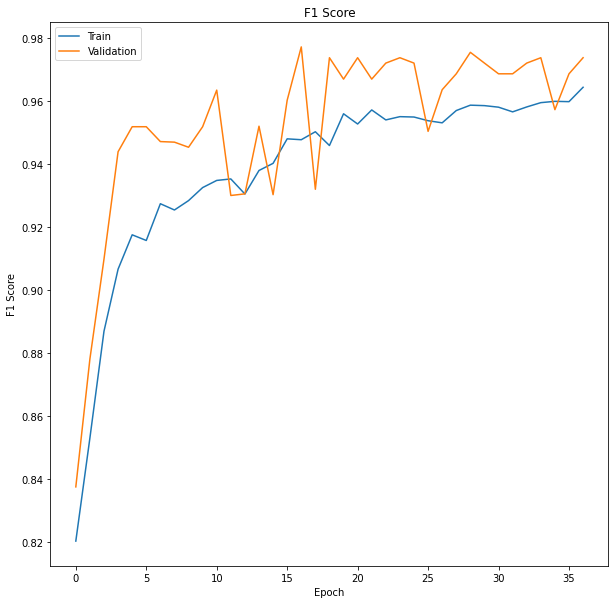

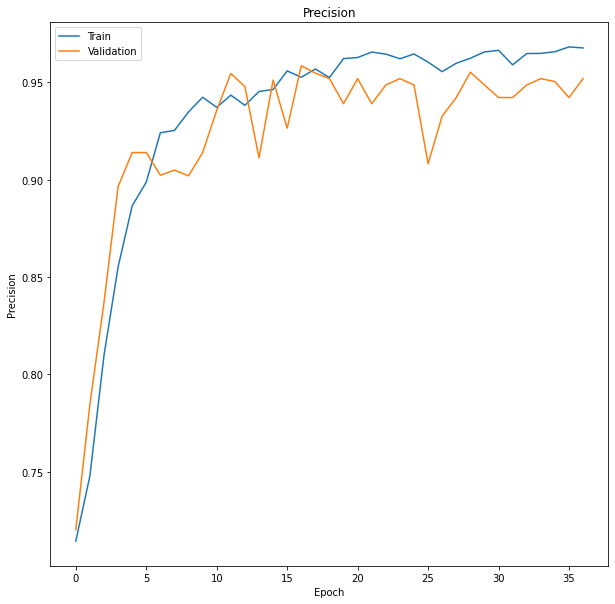

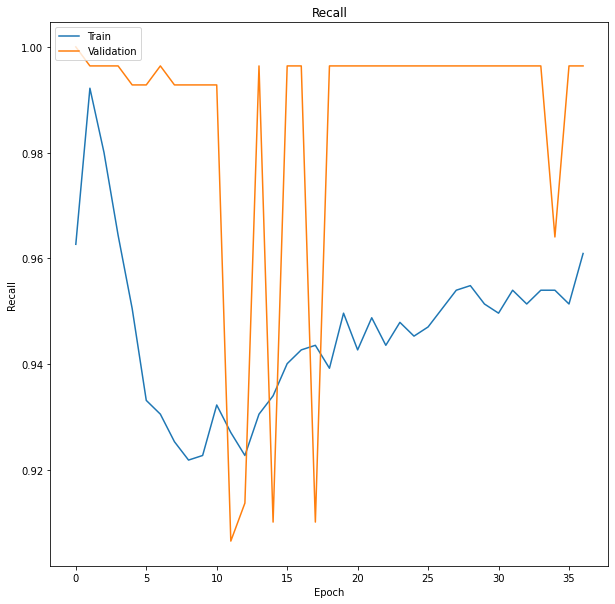

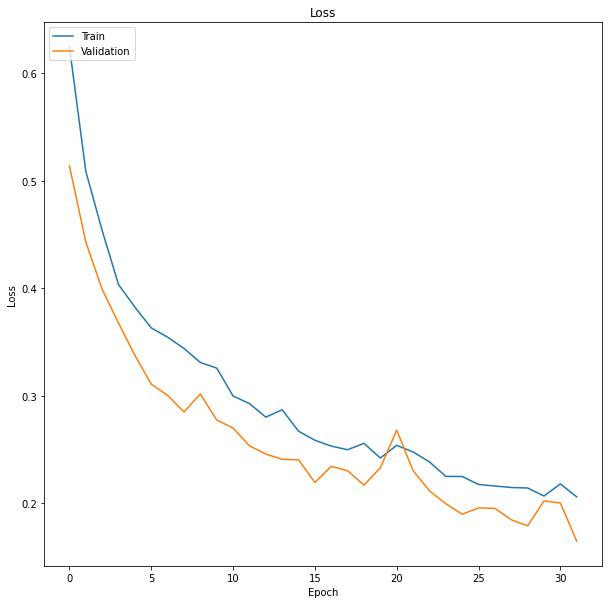

In [341]:
# plot the training history
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'][5:])
plt.plot(history.history['val_loss'][5:])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

12/12 [==============================] - 0s 860us/step
              precision    recall  f1-score   support

         0.0       0.74      0.82      0.78       102
         1.0       0.93      0.89      0.91       271

    accuracy                           0.87       373
   macro avg       0.83      0.86      0.84       373
weighted avg       0.88      0.87      0.87       373



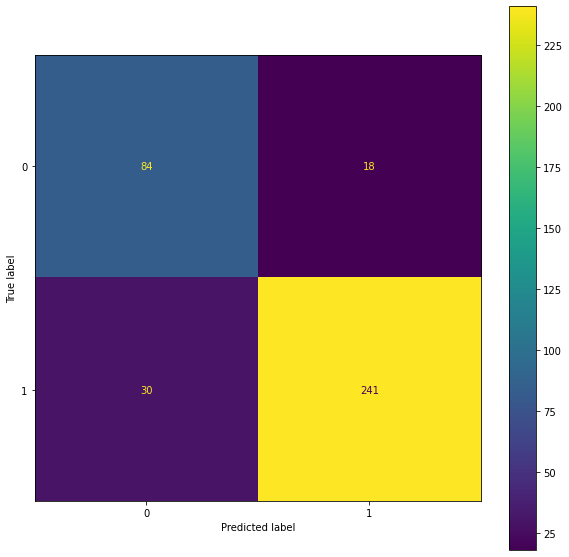

In [299]:
preds = model.predict(X_test)
preds = rint(preds)
# get the f1 score
print(classification_report(y_test, preds))

# get confusion matrix
plt.rcParams['figure.figsize'] = (10, 10)

cm = confusion_matrix(y_test, preds)
# plot confusion matrix

cm = confusion_matrix(y_test, preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()
plt.show()